In [3]:
import pickle
from  test_city import calculate
from multiprocessing import Pool
import contextily as ctx
import networkx as nx
import osmnx as ox

In [50]:
def get_graph(city_id: str = 'R2555133') -> nx.Graph:
    gdf = ox.geocode_to_gdf(city_id, by_osmid=True)
    polygon_boundary = gdf.unary_union
    graph = ox.graph_from_polygon(polygon_boundary,
                                  network_type='drive',
                                  simplify=True)
    G = nx.Graph(graph)
    H = nx.Graph()
    # Добавляем рёбра в новый граф, копируя только веса
    for u, d in G.nodes(data=True):
        H.add_node(u, x=d['x'], y=d['y'])
    for u, v, d in G.edges(data=True):
        H.add_edge(u, v, length=d['length'])
    print(H)
    del city_id, gdf, polygon_boundary, graph, G

get_graph('R8332101')
get_graph('R1250117')

Graph with 746 nodes and 866 edges
Graph with 2098 nodes and 2544 edges


In [35]:
# city_id: R13470549, Graph with 729 nodes and 1068 edges
# city_id: R4676636, Graph with 3349 nodes and 4519 edges
# city_id: R6564910, Graph with 5485 nodes and 7656 edges
# city_id: R71525, Graph with 9517 nodes and 14837 edges
# city_id: R435514, Graph with 21681 nodes and 30128 edges
# city_id: R2555133, Graph with 17793 nodes and 26845 edges
# city_id: R17140517, Graph with 23897 nodes and 35606 edges
# city_id: R62422, Graph with 28088 nodes and 42098 edges
# city_id: R41485, Graph with 43510 nodes and 60563 edges
# city_id: R207359, Graph with 49514 nodes and 72143 edges

In [17]:
total = 6
points_number = 5000

print('THREADS:', total)
print('POINTS:', points_number)

cities = {
    'Durham': 'R8332101',
    'Kamëz': 'R1250117',
    # 'EKB': 'R1250117',
    # 'BARCELONA': 'R347950',
    'Paris': 'R71525',
    'Prague': 'R435514',
    # 'MSK': 'R2555133',
    # 'SBP': 'R337422',
    # 'SINGAPORE': 'R17140517',
    # 'BERLIN': 'R62422',
    # 'ROME': 'R41485',
    # 'LA': 'R207359',
    # 'DUBAI': 'R4479752',
    # 'RIO': 'R2697338',
    # 'DELHI': 'R1942586',
    # 'KAIR': 'R5466227'
}
total_len = len(cities)
l = list(cities.items())
data = [[l[i: total_len: total],points_number, i + 1, total] for i in range(total)]
# print(data)
with Pool(total) as p:
    p.map(calculate, data)

THREADS: 6
POINTS: 5000


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

def scatter_visualisation(speed_up, alphas, errors, name='city', output_dir="data/img", show=False):
    plt.figure(figsize=(16, 9))
    
    # Создаем scatter plot
    scatter = plt.scatter(alphas, speed_up, c=errors, cmap='RdYlGn_r', edgecolor='k', alpha=0.75)
    plt.colorbar(scatter, label='Errors, %')
    
    # Устанавливаем подписи для осей
    plt.ylabel('Speed Up')
    plt.xlabel('Alpha')
    plt.title(f'Speed Up vs Alpha with Error Gradient - {name}')
    
    # Создание папки, если она не существует
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Запись PNG
    file_path = os.path.join(output_dir, f"scatter_speed_up_vs_alpha_{name}.png")
    plt.savefig(file_path, dpi=600)
    
    print(f"Scatter plot saved to {file_path}")
    if show:
        plt.show()
for n in ['Durham', 'Kamëz', 'Paris', 'Prague']:
    with open(f'clusters_results/2024_06_28/{n}.pkl', 'rb') as f:
        data = pickle.load(f)
        # Извлекаем значения speed_up, alpha и errors в отдельные списки
    speed_up = [results.speed_up[0] for results in data.points_results]
    alphas = [results.alpha for results in data.points_results]
    errors = [np.mean(results.errors) * 100 for results in data.points_results]  # усредняем ошибки и масштабируем

    # Вызываем функцию для создания и сохранения scatter plot
    scatter_visualisation(speed_up, alphas, errors, data.name, show=True)

In [ ]:
import requests
import json
import pandas as pd
from tqdm import tqdm

def get_cities_with_population_greater_than_n(n):
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = """
        [out:json];
        (
            relation["place"="city"];
            relation["place"="town"];
            relation["place"="village"];
        );
        out;
    """
    response = requests.get(overpass_url, params={"data": overpass_query})
    data = response.json()

    result = {
        'cities': [],
        'city_ids': [],
        'population_list': [],
        'place': []
    }

    for element in tqdm(data["elements"], leave=False):
        if "population" in element["tags"]:
            population = element["tags"]["population"].replace(" ", "")
            try:
                population = int(population)
                if population >= n:
                    if "name" in element["tags"]:
                        result['cities'].append(element['tags']['name'])  # Добавляем название города в список городов
                        result['city_ids'].append(element['id'])  # Добавляем идентификатор в список идентификаторов
                        result['population_list'].append(element["tags"]["population"].replace(" ", ""))
                        result['place'].append(element['tags']['place'])
            except ValueError:
                # Здесь можно добавить логирование или другую обработку ошибок
                print(f"Не удалось преобразовать население в число для {element['tags'].get('name', 'неизвестного города')}")
    
    return pd.DataFrame(result)  # Возвращаем оба списка    

if __name__ == "__main__":
    min_population = 30000  # Задайте минимальное население
    result = get_cities_with_population_greater_than_n(min_population)

In [19]:
import os
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import osmnx as ox
import warnings
warnings.filterwarnings('ignore')

# Путь к папке с файлами CSV
folder_path = 'data\\csv_1'
files = [f for f in os.listdir(folder_path) if f.startswith('output_R') and f.endswith('.csv')]

# Чтение всех файлов CSV и объединение их в один DataFrame
data_frames = []
for file in files:
    df = pd.read_csv(os.path.join(folder_path, file))
    df['R_number'] = file.split('_R')[1].split('.csv')[0]
    data_frames.append(df)

combined_df = pd.concat(data_frames, ignore_index=True)
combined_df['speed_up'] = combined_df['dijkstra_time'] / combined_df['times']

# Создание словаря для сопоставления city_ids с названием города
city_id_to_name = dict(zip(result['city_ids'], result['cities']))

# Функция для получения центра города по названию города
def get_city_center_by_name(city_name):
    try:
        gdf = ox.geocode_to_gdf(city_name)
        center = gdf.geometry.centroid.iloc[0]
        return gdf, center
    except Exception as e:
        print(f"Failed to get city center for city: {city_name}, error: {e}")
        return None, None

# Получение уникальных значений R_number
unique_r_numbers = combined_df['R_number'].unique()

# Скачивание данных и создание GeoDataFrame
city_data = []
for R_number in tqdm(unique_r_numbers):
    city_name = city_id_to_name.get(int(R_number))
    if city_name:
        place_name, center = get_city_center_by_name(city_name)
        if place_name is not None:
            city_data.append({
                'R_number': R_number,
                'name_city': city_name,
                'geometry': center
            })

city_gdf = gpd.GeoDataFrame(city_data, geometry='geometry', crs='EPSG:4326')

100%|██████████| 756/756 [00:32<00:00, 22.93it/s]


In [ ]:
# Figure Map
fig, ax = plt.subplots(figsize=(16, 9))
city_gdf = city_gdf.to_crs(epsg=3857)
city_gdf.plot(ax=ax, color='red', markersize=5, label='City')
ctx.add_basemap(ax, zoom=1)
ax.set_axis_off()

# Добавление легенды
ax.legend(loc='upper right', fontsize=14)

plt.savefig('data/img/world_map.png', dpi=200, bbox_inches='tight')
plt.show()

In [53]:
import pandas as pd
import networkx as nx
from tqdm import tqdm

# Функция для загрузки графа из файлов формата graphml
def load_graph(graph_filename):
    return nx.read_graphml(graph_filename)

# Создание словаря для хранения информации о графах
graph_info = {}

# Проход по уникальным значениям R_number в DataFrame
for R_number in tqdm(combined_df['R_number'].unique()):
    # Формируем путь к файлу графа
    graph_filename = f'data/graphs_1/graph_R{R_number}.graphml'
    
    # Загружаем граф из файла
    G = load_graph(graph_filename)
    
    # Собираем информацию о графе
    # num_nodes = G.number_of_nodes()
    # num_edges = G.number_of_edges()
    # average_clustering = nx.average_clustering(G)
    # density = nx.density(G)
    # diameter = nx.diameter(G)
    degrees = dict(G.degree())
    
    # Сохраняем информацию в словарь
    graph_info[R_number] = {
    # "Number of Nodes": num_nodes,
    # "Number of Edges": num_edges,
    # "Average Clustering": average_clustering,
    # "Density": density,
    # "Diameter": diameter,
    "Average Degrees": np.array(list(degrees.values())).mean(),

    
}
# Создание новых колонок в combined_df и заполнение их значениями из словаря
# combined_df['diameter'] = combined_df['R_number'].map(lambda x: graph_info[x]['Diameter'])
combined_df['average degrees'] = combined_df['R_number'].map(lambda x: graph_info[x]['Average Degrees'])
# combined_df['nodes'] = combined_df['R_number'].map(lambda x: graph_info[x]['Number of Nodes'])
# combined_df['edges'] = combined_df['R_number'].map(lambda x: graph_info[x]['Number of Edges'])
# combined_df['average_clustering'] = combined_df['R_number'].map(lambda x: graph_info[x]['Average Clustering'])
# combined_df['density'] = combined_df['R_number'].map(lambda x: graph_info[x]['Density'])
# combined_df['avg number of points in cluster'] = combined_df['nodes'] / (combined_df['alpha'] * combined_df['nodes'])
# combined_df.to_csv('For_Gosha.csv')

100%|██████████| 756/756 [03:23<00:00,  3.71it/s]


In [ ]:
import os
import pickle
import matplotlib.pyplot as plt

def box_visualisation(absolute_errors_list, alphas_list, pfa_times_list, names, output_dir="data\\img", show=False):
    # Создаем 2x2 подграфики
    fig, axs = plt.subplots(2, 2, figsize=(16, 9))
    axs = axs.flatten()  # Выравниваем массив подграфиков

    country = {
        'Durham':  'United Kingdom',
        'Kamëz':  'Albania',
        'Paris':  'France',
        'Prague':  'Czech Republic'
    }

    # Параметры для boxplot
    boxprops = {"color": "black", "linewidth": 2, "facecolor": "#35478C"}
    medianprops = {"color": "r", "linewidth": 2}
    whiskerprops = {"color": "black", "linewidth": 2}
    capprops = {"color": "black", "linewidth": 2}

    for i, ax in enumerate(axs):
        # Создаем boxplot на каждом подграфике
        ax.boxplot(absolute_errors_list[i], showfliers=False, vert=True, patch_artist=True,
                   medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)
        ax.set_ylabel('Errors, %', color='#35478C', fontweight=500, fontsize=14)
        ax.set_xlabel('Alpha', fontsize=14)
        ax.set_title(f'Boxplot of Errors - {names[i]} ({country[names[i]]})', fontsize=16)
        ax.set_xticks(range(1, len(alphas_list[i]) + 1))
        ax.set_xticklabels(alphas_list[i])
        ax.set_ylim(0, 100)  # Установка основной вертикальной оси от 0 до 100

        # Наклон текста на оси x
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

        # Создаем второстепенную ось для pfa time
        ax2 = ax.twinx()
        ax2.plot(range(1, len(alphas_list[i]) + 1), pfa_times_list[i], color='r', marker='o', linestyle='-', linewidth=2)
        ax2.set_ylabel('Speed Up', color='r', fontweight=500, fontsize=14)

    # Настройка пространства между подграфиками
    plt.tight_layout()

    # Создание папки, если она не существует
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Запись PNG
    file_path = os.path.join(output_dir, "boxplot_errors_combined.png")
    plt.savefig(file_path, dpi=200, bbox_inches='tight')
    
    print(f"Boxplot saved to {file_path}")
    if show:
        plt.show()

# Списки для хранения данных
absolute_errors_list = []
alphas_list = []
pfa_times_list = []
names = ['Durham', 'Kamëz', 'Paris', 'Prague']

for n in names:
    with open(f'clusters_results\\2024_06_28\\{n}.pkl', 'rb') as f:
        data = pickle.load(f)

        # Извлекаем значения absolute_err, alpha и pfa time в отдельные списки
        absolute_errors = [[i * 100 for i in results.errors] for results in data.points_results]
        alphas = [round(i.alpha, 3) for i in data.points_results]
        speed_up = [i.speed_up[0] for i in data.points_results]

        # Добавляем данные в списки
        absolute_errors_list.append(absolute_errors)
        alphas_list.append(alphas)
        pfa_times_list.append(speed_up)

# Вызываем функцию для создания и сохранения boxplot
box_visualisation(absolute_errors_list, alphas_list, pfa_times_list, names, show=True)

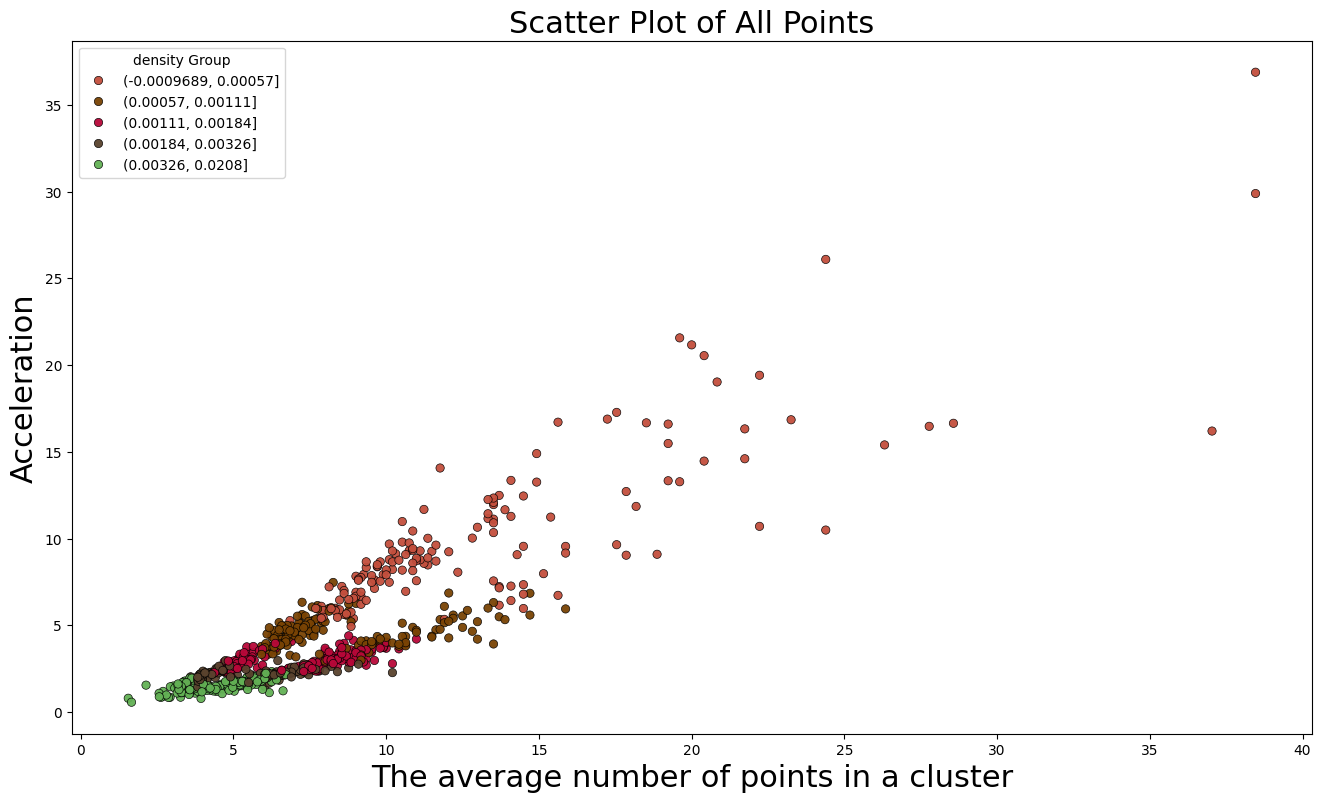

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

def generate_hex_colors(n):
    colors = []
    for _ in range(n):
        color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        colors.append(color)
    return colors

def ploting(df, name, highlight2_name, q=10, highlight=False, highlight2=False, selected_classes=[0], save=False, name_fig='figure'):
    # Находим строки с максимальным значением 'speed_up' для каждого 'R_number'
    if highlight:
        max_speed_up_df = df.loc[df.groupby('R_number')['speed_up'].idxmax()]
    else:
        max_speed_up_df = df

    # Создаем группы на основе квартилей 'nodes'
    colors = generate_hex_colors(q)
    max_speed_up_df[f'{name}_group'] = pd.qcut(max_speed_up_df[name], q=q, labels=[i for i in range(q)])
    max_speed_up_df[f'{name}_group_gap'] = pd.qcut(max_speed_up_df[name], q=q)

    if highlight2:
        max_speed_up_df = max_speed_up_df.loc[max_speed_up_df.groupby('R_number')[highlight2_name].idxmax()]

    # Генерация цветовой палитры, включая серый для невыбранных классов
    palette = {group: (colors[i] if i in selected_classes else '#D3D3D3') for i, group in enumerate(max_speed_up_df[f'{name}_group_gap'].cat.categories)}

    # Построение графика с разбиением по группам 'node_group'
    plt.figure(figsize=(16, 9))
    sns.scatterplot(
        data=max_speed_up_df,
        x='avg number of points in cluster',
        y='speed_up',
        hue=f'{name}_group_gap',
        palette=palette,
        edgecolor='black',
        alpha=0.95
    )

    plt.title('Scatter Plot of All Points', fontsize=22)
    plt.xlabel('The average number of points in a cluster', fontsize=22)
    plt.ylabel('Acceleration', fontsize=22)

    plt.legend(title=f'{name} Group')
    if save:
        plt.savefig(f'data\\img\\{name_fig}.png', dpi=200, bbox_inches='tight')
    plt.show()

df = pd.read_csv('more_info_for_cities.csv')
# df = df[df['node_group'].isin([0,1,2,3,4,5,6,7,8,9])]
ploting(df=combined_df, 
        name='density', 
        highlight2_name='speed_up', 
        q=5, 
        highlight=True, 
        highlight2=False, 
        selected_classes=[i for i in range(0, 10, 1)],
        save=False,
        name_fig='Scatter Plot of All Points')

In [32]:
import pandas as pd
from scipy.stats import pearsonr

df = pd.read_csv('graphs_data.csv')
results = pd.DataFrame(columns=['node_group', 'node_group_gap', 'correlation', 'p_value'])

# Цикл по каждой группе
for i in range(20):
    group_df = df[['avg number of points in cluster', 'modularity', 'node_group', 'node_group_gap']][df.node_group == i]

    if not group_df.empty and len(group_df) > 1:
        corr, p_value = pearsonr(group_df['avg number of points in cluster'], group_df['modularity'])
    else:
        corr, p_value = None, None
    
    node_group_gap = group_df['node_group_gap'].iloc[0] if not group_df.empty else None
    results = pd.concat([results, pd.DataFrame({'node_group': [i], 'node_group_gap': [node_group_gap], 'correlation': [corr], 'p_value': [p_value]})], ignore_index=True)

mean_correlation = results['correlation'].mean()
mean_p_value = results['p_value'].mean()
significant_correlations = (results['p_value'] < 0.05).sum()

print(f"Средняя корреляция: {mean_correlation:.8f}")
print(f"Среднее p-value: {mean_p_value:.8f}")
print(f"Количество значимых корреляций (p-value < 0.05): {significant_correlations}")

results

Средняя корреляция: 0.55758717
Среднее p-value: 0.04616207
Количество значимых корреляций (p-value < 0.05): 19


C:\Users\local\AppData\Local\Temp\ipykernel_17876\1724032092.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'node_group': [i], 'node_group_gap': [node_group_gap], 'correlation': [corr], 'p_value': [p_value]})], ignore_index=True)


,node_group,node_group_gap,correlation,p_value
0,0,"(107.999, 385.0]",-0.005260,9.232415e-01
1,1,"(385.0, 586.0]",0.361171,1.234144e-11
2,2,"(586.0, 742.0]",0.480992,3.202205e-20
3,3,"(742.0, 849.0]",0.511887,1.947030e-23
4,4,"(849.0, 1008.0]",0.548266,9.276712e-28
5,5,"(1008.0, 1119.0]",0.558631,2.152726e-28
6,6,"(1119.0, 1291.0]",0.560151,1.731834e-28
7,7,"(1291.0, 1453.0]",0.580771,4.609216e-31
8,8,"(1453.0, 1629.0]",0.586571,2.945618e-32
9,9,"(1629.0, 1865.0]",0.614020,1.105503e-35


In [34]:
df = pd.read_csv('graphs_data.csv')
results = pd.DataFrame(columns=['node_group', 'node_group_gap', 'correlation', 'p_value'])
correlation, p_value = pearsonr(df['avg number of points in cluster'], df['modularity'])

print(f"Средняя корреляция: {correlation}")
print(f"Среднее p-value: {p_value}")
# print(f"Количество значимых корреляций (p-value < 0.05): {significant_correlations}")

Средняя корреляция: 0.5524419651498609
Среднее p-value: 0.0
